# Log of changes from original calculation

* Urban/rural split is now based on MSASIZE instead of URBRUR variable from NHTS. Now "rural" is outside of any MSA, instead of just not in an urbanized region.
* Added an option to include demand from transit trips in addition to private vehicles and taxis.
* Now breaking down into three different times of week: Sa/Su, M/F, and Tu/W/Th.

# Important things to note:
* This provides the *trip* demand, where a trip is point-to-point travel for one or more members of the same household. So if a family of six all takes the bus, that's *one* trip. This has implications for our assumptions about the sharing factor.
* Trips >=300 mi. are thrown out
* This produces *annual* trip demand values. So for the TU/WE/TH midweek time period, this is all trips on all Tuesdays, Wednesdays, and Thursdays for the whole year. Need to multiply by 7/3./365. to get a daily value.

# To do
* Seasonal variation

In [192]:
import pandas as pd
import numpy as np

import matplotlib.gridspec as gridspec
%matplotlib notebook

## Set up

In [193]:
#Point to a directory containing the NHTS trippub.csv dataset
data_dir = 'C:\\Users\\bgerke.DOMINO0\\Desktop\\NHTS\\'

#Should we include demand from trips on mass transit (public transit, school buses, private shuttles, etc.)?
include_transit = True



In [194]:
#Read in main dataset
trippub_all = pd.read_csv(data_dir+'trippub.csv')
trippub_all.head()
#Trips

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,HTRESDN,SMPLSRCE,R_AGE,EDUC,R_SEX,PRMACT,PROXY,WORKER,DRIVER,WTTRDFIN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,750,2,67,3,2,6,1,2,1,75441.905796
2,30000007,2,1,700,900,120,84.004,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,750,2,66,3,1,1,2,1,1,71932.645806
4,30000007,3,1,845,900,15,2.250,3,0,0,...,750,2,28,2,2,5,2,2,1,80122.686739


In [195]:
trippub_all.columns.values

array(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'STRTTIME', 'ENDTIME',
       'TRVLCMIN', 'TRPMILES', 'TRPTRANS', 'TRPACCMP', 'TRPHHACC',
       'VEHID', 'TRWAITTM', 'NUMTRANS', 'TRACCTM', 'DROP_PRK', 'TREGRTM',
       'WHODROVE', 'WHYFROM', 'LOOP_TRIP', 'TRPHHVEH', 'HHMEMDRV',
       'HH_ONTD', 'NONHHCNT', 'NUMONTRP', 'PSGR_FLG', 'PUBTRANS',
       'TRIPPURP', 'DWELTIME', 'TDWKND', 'VMT_MILE', 'DRVR_FLG',
       'WHYTRP1S', 'WHYTRP90', 'ONTD_P1', 'ONTD_P2', 'ONTD_P3', 'ONTD_P4',
       'ONTD_P5', 'ONTD_P6', 'ONTD_P7', 'ONTD_P8', 'ONTD_P9', 'ONTD_P10',
       'ONTD_P11', 'ONTD_P12', 'ONTD_P13', 'TDCASEID', 'TRACC_WLK',
       'TRACC_POV', 'TRACC_BUS', 'TRACC_CRL', 'TRACC_SUB', 'TRACC_OTH',
       'TREGR_WLK', 'TREGR_POV', 'TREGR_BUS', 'TREGR_CRL', 'TREGR_SUB',
       'TREGR_OTH', 'WHYTO', 'TRAVDAY', 'HOMEOWN', 'HHSIZE', 'HHVEHCNT',
       'HHFAMINC', 'DRVRCNT', 'HHSTATE', 'HHSTFIPS', 'NUMADLT',
       'WRKCOUNT', 'TDAYDATE', 'HHRESP', 'LIF_CYC', 'MSACAT', 'MSASIZE',
       'RAIL', 'URBAN', '

In [196]:
#Personal motor vehicle codes from code book
#This is car, suv, van, pickup truck,  motorcycle, RV, rental car
#LEAVES OUT 17-taxis/TNCs, because (I believe) we cannot weight these correctly since must weight by driver. 

pmvcodes = [3,4,5,6,8,9,18]
selection = (trippub_all['TRPTRANS'].isin(pmvcodes)) & (trippub_all['DRVR_FLG']==1)


    
trippub = trippub_all.loc[selection]
print(trippub['TRPTRANS'].count())
print(trippub['WTTRDFIN'].sum())


611342
220429661377.4252


In [197]:
taxitrips = trippub_all.loc[trippub_all['TRPTRANS']==17].groupby(
    ['HOUSEID','TDAYDATE','STRTTIME'], as_index=False).first()
#The above cuts out duplicate trips, where two people in the same household reported the same taxi trip. Serves
#a similar purpose to restricting by driver flag
trippub = trippub.append(taxitrips)
trippub.reset_index(drop=True, inplace=True)
print(taxitrips['TRPTRANS'].count())
print(taxitrips['WTTRDFIN'].sum())
#Surprisingly few taxi trips...

2394
1615969202.3435988


In [198]:
if include_transit:
    print('Including transit trips in total.')
    #Transit vehicle codes from code book are 10-16 
    trnstcodes = list(range(10,17))
    trnsttrips = trippub_all.loc[trippub_all['TRPTRANS'].isin(trnstcodes)].groupby(
        ['HOUSEID','TDAYDATE','STRTTIME'], as_index=False).first()
    trippub = trippub.append(trnsttrips)
    trippub.reset_index(drop=True, inplace=True)
    print(trnsttrips['TRPTRANS'].count())
    print(trnsttrips['WTTRDFIN'].sum())
else:
    print('Excluding transit trips from total')

Including transit trips in total.
21890
15763885231.569706


In [199]:
#Total raw and weighted trip numbers
print(trippub['TRPTRANS'].count())
print(trippub['WTTRDFIN'].sum())

635626
237809515811.33847


In [200]:
#Print avg mileages by trip type
print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())
print(taxitrips['TRPMILES'].mul(taxitrips['WTTRDFIN']).sum()/taxitrips['WTTRDFIN'].sum())
if include_transit: 
    print(trnsttrips['TRPMILES'].mul(trnsttrips['WTTRDFIN']).sum()/trnsttrips['WTTRDFIN'].sum())

9.541925770577617
8.222858752112181
9.524062680108994


In [201]:
trippub.tail()

,CDIVMSAR,CENSUS_D,CENSUS_R,DRIVER,DROP_PRK,DRVRCNT,DRVR_FLG,DWELTIME,EDUC,ENDTIME,...,VEHID,VMT_MILE,WHODROVE,WHYFROM,WHYTO,WHYTRP1S,WHYTRP90,WORKER,WRKCOUNT,WTTRDFIN
635621,33,3,2,-1,-1,2,-1,420,-1,730,...,-1,-1.0,-1,1,8,20,5,-1,2,8.798585e+04
635622,33,3,2,-1,-1,2,-1,-9,-1,1500,...,-1,-1.0,-1,8,1,1,5,-1,2,8.798585e+04
635623,21,2,1,1,2,3,-1,505,4,935,...,-1,-1.0,-1,1,3,10,1,1,3,1.314464e+06
635624,21,2,1,1,-1,3,-1,-9,4,1955,...,-1,-1.0,-1,3,1,1,1,1,3,1.314464e+06
635625,53,5,3,-1,-1,2,-1,-9,1,1545,...,-1,-1.0,-1,8,1,1,5,-1,2,1.596153e+05


In [202]:
#Trim out long road trips
trippub = trippub.loc[trippub['TRPMILES'] < 300]
print(len(trippub))
print(trippub['WTTRDFIN'].sum())

print(trippub['TRPMILES'].mul(trippub['WTTRDFIN']).sum()/trippub['WTTRDFIN'].sum())

635052
237581417926.02374
8.910031495709765


In [203]:
#Create Census Division/ Large State category with urban/rural split.
#Also Census region urban/rural split
cdiv = {1:'NENG', 2:'MAT', 3:'ENC', 4:'WNC', 5:'SAT', 6:'ESC', 7:'WSC', 8:'MTN', 9:'PAC'}
creg = {1:'NEAST', 2:'MIDW', 3:'SOUTH', 4:'WEST'}

for k in cdiv.keys():
    trippub.loc[trippub['CENSUS_D']==k, 'CDIVLS'] = cdiv[k]
for k in creg.keys():
    trippub.loc[trippub['CENSUS_R']==k, 'REGION'] = creg[k]

lgst = ['CA', 'NY','FL','TX']

for s in lgst:
    div = cdiv[trippub.loc[trippub['HHSTATE']==s, 'CENSUS_D'].unique()[0]]
    #print reg
    trippub.loc[(trippub['HHSTATE']==s), 'CDIVLS'] = div+'-'+s
    trippub.loc[(trippub['CDIVLS']==div) & (trippub['HHSTATE']!=s), 'CDIVLS'] = div+'-NL' 
    

#Turn urban/rural codes into strings    
trippub['URBRURS'] = 'RUR'
#trippub.loc[trippub['URBRUR'] == 1, 'URBRURS'] = 'URB'
#Instead of the above, divide urban vs rural according to metropolitan statistical area size: all MSAs are urban
trippub.loc[trippub['MSASIZE']<6,'URBRURS'] = 'URB'


print trippub['CDIVLS'].unique()
print trippub['REGION'].unique()
print trippub['URBRURS'].unique()

['SAT-NL' 'ENC' 'MAT-NY' 'MAT-NL' 'PAC-CA' 'WSC-TX' 'PAC-NL' 'ESC' 'MTN'
 'WNC' 'NENG' 'SAT-FL' 'WSC-NL']
['SOUTH' 'MIDW' 'NEAST' 'WEST']
['URB' 'RUR']


In [204]:
#Code different times of week.
wktime = {'SA/SU':[1,7], 'MO/FR':[2,6], 'TU/WE/TH': [3,4,5]}
trippub['WKTIME'] = ''
for k in wktime.keys():
    trippub.loc[trippub['TRAVDAY'].isin(wktime[k]), 'WKTIME'] = k
print trippub['WKTIME'].unique()

['MO/FR' 'TU/WE/TH' 'SA/SU']


In [205]:
#Set mileage bin edges
mibins=[0,2,5,10,20,30,50,100,300]
mibin_labels=pd.Series(mibins[:-1]).astype(str).str.cat(pd.Series(mibins[1:]).astype(str), sep='-')

In [206]:
#Categorize trips by mileage

trippub['MILEBIN'] = pd.cut(trippub['TRPMILES'], mibins, labels=mibin_labels)


In [207]:
#Compute distance histograms (and average distances) by CDLS

dist_hists = trippub.groupby(['CDIVLS', 'URBRURS',
                              'WKTIME','MILEBIN']).agg({'WTTRDFIN':[len, np.sum], 
                                                               'TRPMILES':np.mean,
                                                               'REGION':'first'}
                                                       ).rename(columns=
                                                                {'mean':'AVGDIST',
                                                                 'first':'REGION', 
                                                                 'len':'COUNTSRAW',
                                                                 'sum':'COUNTSWTD'}, level=1)

dist_hists.columns = dist_hists.columns.droplevel(0)
dist_hists

#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

AVGDIST REGION  COUNTSRAW     COUNTSWTD
CDIVLS URBRURS WKTIME   MILEBIN                                            
ENC    RUR     MO/FR    0-2        0.977429   MIDW     2053.0  7.365273e+08
                        2-5        3.231085   MIDW     1298.0  3.772505e+08
                        5-10       7.281436   MIDW     1002.0  2.685436e+08
                        10-20     14.354197   MIDW      879.0  2.740703e+08
                        20-30     24.290520   MIDW      369.0  1.134880e+08
                        30-50     38.296500   MIDW      294.0  7.924429e+07
                        50-100    65.612557   MIDW      149.0  3.309224e+07
                        100-300  163.518387   MIDW       75.0  1.288694e+07
               SA/SU    0-2        0.990881   MIDW      904.0  5.914655e+08
                        2-5        3.264059   MIDW      522.0  3.314264e+08
                        5-10       7.174956   MIDW      363.0  2.181214e+08
                        10-20     13.877851   MIDW      376.0  2.276380e+08
                        20-30     24.590622   MIDW      135.0  9.867586e+07
                        30-50     39.451236   MIDW      110.0  7.459379e+07
                        50-100    66.330979   MIDW       96.0  4.167240e+07
                        100-300  154.722333   MIDW       33.0  1.720882e+07
               TU/WE/TH 0-2        0.972198   MIDW     3018.0  8.716086e+08
                        2-5        3.263572   MIDW     1871.0  5.865779e+08
                        5-10       7.266915   MIDW     1482.0  4.749664e+08
                        10-20     14.300158   MIDW     1366.0  5.242017e+08
                        20-30     24.381568   MIDW      562.0  1.770732e+08
                        30-50     38.323571   MIDW      462.0  1.505918e+08
                        50-100    67.778822   MIDW      180.0  4.419798e+07
                        100-300  156.786339   MIDW       59.0  1.006733e+07
       URB     MO/FR    0-2        1.091301   MIDW     5464.0  2.366709e+09
                        2-5        3.299593   MIDW     5786.0  2.489039e+09
                        5-10       7.128054   MIDW     3777.0  1.739570e+09
                        10-20     14.064110   MIDW     2660.0  1.251727e+09
                        20-30     23.916630   MIDW      841.0  4.605324e+08
                        30-50     37.600925   MIDW      517.0  2.568254e+08
...                                     ...    ...        ...           ...
WSC-TX RUR     TU/WE/TH 5-10       7.225261  SOUTH      752.0  1.262966e+08
                        10-20     14.060794  SOUTH      713.0  1.304878e+08
                        20-30     24.993852  SOUTH      284.0  4.874912e+07
                        30-50     38.525837  SOUTH      294.0  4.158224e+07
                        50-100    66.838243  SOUTH      173.0  2.906139e+07
                        100-300  177.377809  SOUTH       47.0  6.633365e+06
       URB     MO/FR    0-2        1.112937  SOUTH    11094.0  1.425143e+09
                        2-5        3.309249  SOUTH    11970.0  1.545101e+09
                        5-10       7.110423  SOUTH     7613.0  9.971863e+08
                        10-20     14.138933  SOUTH     6089.0  8.016910e+08
                        20-30     24.071358  SOUTH     2383.0  3.030889e+08
                        30-50     37.079675  SOUTH     1209.0  1.508032e+08
                        50-100    68.336914  SOUTH      418.0  4.922806e+07
                        100-300  170.215309  SOUTH      269.0  3.273075e+07
               SA/SU    0-2        1.100384  SOUTH     3874.0  1.180684e+09
                        2-5        3.305593  SOUTH     4304.0  1.286707e+09
                        5-10       7.117384  SOUTH     2691.0  8.256438e+08
                        10-20     14.155108  SOUTH     1856.0  5.653556e+08
                        20-30     24.023736  SOUTH      694.0  2.186641e+08
                        30-50     37.755050  SOUTH      377.0  1.106647e+08
        

In [208]:
#Check avg mileages
print(dist_hists['AVGDIST'].mul(dist_hists['COUNTSWTD']).sum()/dist_hists['COUNTSWTD'].sum())

8.907404971826649


In [209]:
trippub['STRTHOUR'] = pd.cut(trippub['STRTTIME'], np.arange(25)*100, labels=np.arange(24))

In [210]:
#Compute hourly trip volume profiles by region and urb/rural

hourly_profiles = trippub.groupby(['REGION', 
                                   'URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
#NOTE: COUNTSWTD here represents the total ANNNUAL number of trips in each bin.

In [211]:
hourly_profiles

COUNTSRAW     COUNTSWTD
REGION URBRURS WKTIME   MILEBIN STRTHOUR                         
MIDW   RUR     MO/FR    0-2     0               2.0  2.815297e+06
                                1               1.0  3.220029e+05
                                2               1.0  3.220029e+05
                                3               1.0  4.899141e+06
                                4              16.0  2.741188e+06
                                5              35.0  1.733291e+07
                                6              74.0  3.852619e+07
                                7             169.0  1.068498e+08
                                8             151.0  9.021114e+07
                                9             186.0  1.055746e+08
                                10            187.0  1.055917e+08
                                11            241.0  1.362431e+08
                                12            244.0  1.262910e+08
                                13            192.0  1.186545e+08
                                14            172.0  7.378287e+07
                                15            237.0  1.309153e+08
                                16            210.0  9.748937e+07
                                17            154.0  8.293744e+07
                                18            113.0  7.089202e+07
                                19             61.0  3.242137e+07
                                20             54.0  2.498292e+07
                                21             32.0  3.969142e+07
                                22             19.0  2.004511e+07
                                23              5.0  1.144201e+06
                        2-5     0               2.0  6.533857e+05
                                1               2.0  1.117313e+06
                                3               1.0  1.198312e+05
                                4              14.0  7.852458e+06
                                5              26.0  7.492990e+06
                                6              62.0  2.930163e+07
...                                             ...           ...
WEST   URB     TU/WE/TH 50-100  15             62.0  2.009426e+07
                                16             70.0  3.160843e+07
                                17             34.0  9.547801e+06
                                18             32.0  1.630817e+07
                                19             23.0  5.489079e+06
                                20             24.0  5.872926e+06
                                21              9.0  2.369436e+06
                                22              4.0  8.011899e+05
                                23              3.0  1.173666e+06
                        100-300 1               1.0  1.798080e+05
                                4              18.0  5.084339e+06
                                5              14.0  2.149766e+06
                                6              26.0  7.510078e+06
                                7              26.0  4.412659e+06
                                8              20.0  3.415251e+06
                                9              39.0  7.321508e+06
                                10             26.0  6.266206e+06
                                11             21.0  5.780801e+06
                                12             40.0  1.005131e+07
                                13             19.0  2.501428e+06
                                14             28.0  7.031987e+06
                                15             22.0  5.752066e+06
                                16             24.0  9.078090e+06
                                17             15.0  3.164238e+06
                                18             17.0  2.261829e+06
                                19             10.0  2.668042e+06
                                20              5.0  2.046922e+06
                                21              6.0  1.489950e+06
                

In [212]:
hourly_profiles['TRIPPCT'] = 0
for row in [(a,b,c,d) 
            for a in hourly_profiles.index.levels[0].unique() 
            for b in hourly_profiles.index.levels[1].unique() 
            for c in hourly_profiles.index.levels[2].unique() 
            for d in hourly_profiles.index.levels[3].unique()]:
    pct=hourly_profiles.loc[row,'COUNTSWTD']/(hourly_profiles.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [213]:
hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T

REGION        MIDW                                                    \
URBRURS        RUR                                                     
WKTIME       MO/FR                                                     
MILEBIN        0-2       2-5      5-10     10-20     20-30     30-50   
STRTHOUR                                                               
0         0.001968  0.000942  0.004287  0.009805  0.023352  0.000112   
1         0.000225  0.001610  0.000276  0.000164  0.000000  0.000000   
2         0.000225  0.000000  0.000407  0.000394  0.000000  0.000000   
3         0.003424  0.000173  0.000217  0.000000  0.000626  0.000291   
4         0.001916  0.011317  0.028500  0.005154  0.023082  0.017189   
5         0.012115  0.010799  0.005468  0.032767  0.022143  0.035281   
6         0.026929  0.042229  0.048411  0.075674  0.111509  0.201178   
7         0.074685  0.097363  0.094418  0.103394  0.105384  0.069065   
8         0.063055  0.042089  0.051273  0.043895  0.024613  0.051323   
9         0.073793  0.059159  0.060742  0.031881  0.037657  0.072721   
10        0.073805  0.066672  0.060016  0.045772  0.048076  0.032061   
11        0.095230  0.062854  0.074461  0.039487  0.061953  0.021265   
12        0.088274  0.063812  0.041973  0.054404  0.052847  0.034354   
13        0.082936  0.078379  0.062814  0.051698  0.096589  0.067761   
14        0.051572  0.069013  0.075170  0.072738  0.021885  0.029723   
15        0.091506  0.092209  0.067288  0.117538  0.046018  0.113737   
16        0.068142  0.075637  0.075466  0.111978  0.117311  0.094568   
17        0.057971  0.080436  0.092984  0.089749  0.081649  0.063130   
18        0.049551  0.037355  0.047940  0.027270  0.032865  0.037066   
19        0.022662  0.050219  0.051166  0.004859  0.013921  0.006291   
20        0.017462  0.007941  0.009940  0.027704  0.015664  0.034586   
21        0.027743  0.026315  0.006619  0.039781  0.018173  0.013175   
22        0.014011  0.015807  0.022862  0.013640  0.024065  0.004221   
23        0.000800  0.007671  0.017300  0.000253  0.020617  0.000905   

REGION                                              ...         WEST  \
URBRURS                                             ...          URB   
WKTIME                           SA/SU              ...        SA/SU   
MILEBIN     50-100   100-300       0-2       2-5    ...       50-100   
STRTHOUR                                            ...                
0         0.067210  0.000000  0.000559  0.005031    ...     0.008078   
1         0.000000  0.000000  0.000000  0.000000    ...     0.003940   
2         0.000000  0.000000  0.001205  0.000000    ...     0.000000   
3         0.001220  0.000000  0.003252  0.000000    ...     0.000000   
4         0.023917  0.013611  0.009119  0.008179    ...     0.024303   
5         0.005015  0.185100  0.010472  0.010602    ...     0.017214   
6         0.083333  0.029019  0.017996  0.030094    ...     0.054573   
7         0.006231  0.059962  0.034459  0.025058    ...     0.021396   
8         0.049672  0.104679  0.050591  0.067775    ...     0.042858   
9         0.053150  0.014323  0.094035  0.071187    ...     0.093366   
10        0.024431  0.006887  0.078303  0.096370    ...     0.098342   
11        0.105415  0.048993  0.124356  0.096982    ...     0.065346   
12        0.083809  0.026743  0.088877  0.062421    ...     0.077886   
13        0.116854  0.311354  0.091706  0.088412    ...     0.083660   
14        0.024639  0.110090  0.091330  0.085965    ...     0.040554   
15        0.117207  0.008959  0.070866  0.079626    ...     0.062906   
16        0.094898  0.010385  0.053131  0.059908    ...     0.071612   
17        0.050170  0.053282  0.050152  0.075797    ...     0.073682   
18        0.004511  0.005009  0.034695  0.060618    ...     0.048730   
19        0.087046  0.000000  0.025743  0.018661    ...     0.046605   
20        0.000631  0.011604  0.009598  0.024187    ...     0.024357   
21        0.000000  0.000000  0.030694 

In [214]:
hourly_profiles_agg = trippub.groupby(['URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})

In [215]:
hourly_profiles_agg['TRIPPCT'] = 0
for row in [(a,b,c) 
            for a in hourly_profiles_agg.index.levels[0].unique() 
            for b in hourly_profiles_agg.index.levels[1].unique() 
            for c in hourly_profiles_agg.index.levels[2].unique()]:
    pct=hourly_profiles_agg.loc[row,'COUNTSWTD']/(hourly_profiles_agg.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles_agg.loc[row+(h,), 'TRIPPCT'] = pct[h]

In [216]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME   MILEBIN STRTHOUR                                   
RUR     MO/FR    0-2     0               6.0  3.686144e+06  0.000966
                         1               8.0  9.804437e+06  0.002571
                         2               1.0  3.220029e+05  0.000084
                         3               1.0  4.899141e+06  0.001285
                         4              29.0  3.587461e+06  0.000941
                         5              88.0  3.292373e+07  0.008632
                         6             232.0  9.493033e+07  0.024890
                         7             680.0  2.988308e+08  0.078351
                         8             546.0  2.453281e+08  0.064323
                         9             709.0  2.261331e+08  0.059290
                         10            821.0  2.633558e+08  0.069050
                         11            984.0  3.151545e+08  0.082631
                         12            991.0  3.572513e+08  0.093669
                         13            808.0  2.912399e+08  0.076361
                         14            836.0  2.813010e+08  0.073755
                         15            922.0  3.729655e+08  0.097789
                         16            794.0  3.071244e+08  0.080526
                         17            609.0  2.514641e+08  0.065932
                         18            401.0  1.810242e+08  0.047463
                         19            220.0  9.051126e+07  0.023731
                         20            181.0  7.440041e+07  0.019507
                         21            106.0  5.901752e+07  0.015474
                         22             46.0  2.751623e+07  0.007215
                         23             29.0  2.121847e+07  0.005563
                 2-5     0               6.0  4.572063e+06  0.001941
                         1               4.0  1.554191e+06  0.000660
                         3               2.0  3.235058e+05  0.000137
                         4              32.0  1.362102e+07  0.005783
                         5              84.0  2.877349e+07  0.012215
                         6             233.0  1.046362e+08  0.044421
...                                      ...           ...       ...
URB     TU/WE/TH 50-100  17            178.0  6.594758e+07  0.071462
                         18            123.0  4.431550e+07  0.048021
                         19             74.0  1.524403e+07  0.016519
                         20             69.0  1.106856e+07  0.011994
                         21             38.0  5.375190e+06  0.005825
                         22             25.0  1.175407e+07  0.012737
                         23              9.0  3.767786e+06  0.004083
                 100-300 0               1.0  1.338488e+04  0.000037
                         1               2.0  2.409549e+05  0.000674
                         3               4.0  2.328788e+05  0.000652
                         4              48.0  1.608052e+07  0.045005
                         5              49.0  1.898431e+07  0.053132
                         6              94.0  2.389395e+07  0.066873
                         7             108.0  2.971208e+07  0.083156
                         8             110.0  2.159247e+07  0.060431
                         9             131.0  3.511721e+07  0.098283
                         10             98.0  1.848568e+07  0.051736
                         11            109.0  2.376506e+07  0.066512
                         12            137.0  3.388584e+07  0.094837
                         13             91.0  1.605296e+07  0.044928
                         14            123.0  1.958930e+07  0.054825
                         15            100.0  2.022665e+07  0.056609
                         16             94.0  2.570211e+07  0.071933
                         17             57.0  2.233748e+07  0.062516
                         18             49.0  1.526282e+07  0.042716
                         19      

<IPython.core.display.Javascript object>


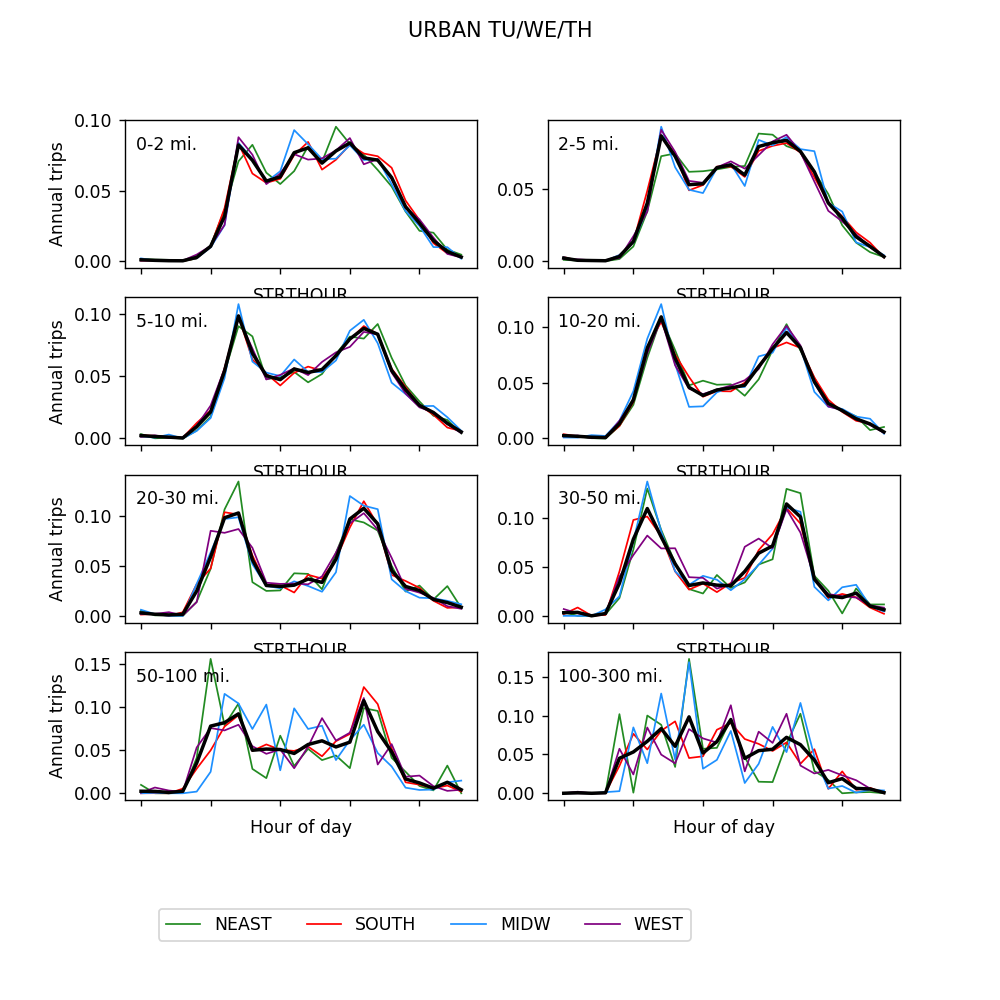

('NEAST', 'URB', 'TU/WE/TH')
('SOUTH', 'URB', 'TU/WE/TH')
('MIDW', 'URB', 'TU/WE/TH')
('WEST', 'URB', 'TU/WE/TH')


In [217]:
def plot_dists_by_region(plotdata, regions=['NEAST','SOUTH','MIDW','WEST'], urbrur='URB', wktime='WEEKDAY',
                         alldata = None,
                         colors=None):
    fig = plt.figure()
    gs = gridspec.GridSpec(nrows=4, ncols=2, bottom=0.2)

    for i in range(len(mibins[:-1])):
        fig.add_subplot(gs[i/2, i%2])

    axs = fig.axes
    
    if not colors:
        colors=['forestgreen','red','dodgerblue','purple']

    #plotdata = dists.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
    for i, reg in enumerate(regions):
        sel=(reg,urbrur,wktime)
        print sel
        #plotdata = dists.loc[sel].unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
        #plotdata.index = np.arange(24)
        plotdata[sel].plot(subplots=True, legend=None, color=colors[i], ax=axs, linewidth=1)

    if alldata is not None:
        alldata[(urbrur,wktime)].plot(subplots=True, legend=None,color='k', ax=axs, linewidth=2)
    for i, ax in enumerate(axs):
        col = plotdata[sel].columns[i]
        miles = col.split('-')
        ax.annotate(str(miles[0])+'-'+str(miles[1])+' mi.', [0.03,0.8], xycoords='axes fraction')
        if i > 5:
            ax.set_xlabel('Hour of day')
            
        if i % 2 == 0:
            ax.set_ylabel('Annual trips')

    plt.legend(ax.lines, regions,ncol=4, loc=2, bbox_to_anchor=(0.15,0.1), bbox_transform=fig.transFigure)
    
    if urbrur == 'URB': 
        urname='URBAN' 
    else: 
        urname='RURAL'
    fig.suptitle(urname+' '+wktime)
    
plt.rcParams['figure.figsize'] = [8, 8]    
plotdata = hourly_profiles.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
alldata = hourly_profiles_agg.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
plot_dists_by_region(plotdata, urbrur='URB', wktime='TU/WE/TH', alldata=alldata)

In [218]:
dist_hour_hists = dist_hists.copy()
dist_hour_hists.rename(columns={'COUNTSRAW':'NRAW', 'COUNTSWTD':'NWTD'},inplace=True)
dist_hour_hists

AVGDIST REGION     NRAW          NWTD
CDIVLS URBRURS WKTIME   MILEBIN                                          
ENC    RUR     MO/FR    0-2        0.977429   MIDW   2053.0  7.365273e+08
                        2-5        3.231085   MIDW   1298.0  3.772505e+08
                        5-10       7.281436   MIDW   1002.0  2.685436e+08
                        10-20     14.354197   MIDW    879.0  2.740703e+08
                        20-30     24.290520   MIDW    369.0  1.134880e+08
                        30-50     38.296500   MIDW    294.0  7.924429e+07
                        50-100    65.612557   MIDW    149.0  3.309224e+07
                        100-300  163.518387   MIDW     75.0  1.288694e+07
               SA/SU    0-2        0.990881   MIDW    904.0  5.914655e+08
                        2-5        3.264059   MIDW    522.0  3.314264e+08
                        5-10       7.174956   MIDW    363.0  2.181214e+08
                        10-20     13.877851   MIDW    376.0  2.276380e+08
                        20-30     24.590622   MIDW    135.0  9.867586e+07
                        30-50     39.451236   MIDW    110.0  7.459379e+07
                        50-100    66.330979   MIDW     96.0  4.167240e+07
                        100-300  154.722333   MIDW     33.0  1.720882e+07
               TU/WE/TH 0-2        0.972198   MIDW   3018.0  8.716086e+08
                        2-5        3.263572   MIDW   1871.0  5.865779e+08
                        5-10       7.266915   MIDW   1482.0  4.749664e+08
                        10-20     14.300158   MIDW   1366.0  5.242017e+08
                        20-30     24.381568   MIDW    562.0  1.770732e+08
                        30-50     38.323571   MIDW    462.0  1.505918e+08
                        50-100    67.778822   MIDW    180.0  4.419798e+07
                        100-300  156.786339   MIDW     59.0  1.006733e+07
       URB     MO/FR    0-2        1.091301   MIDW   5464.0  2.366709e+09
                        2-5        3.299593   MIDW   5786.0  2.489039e+09
                        5-10       7.128054   MIDW   3777.0  1.739570e+09
                        10-20     14.064110   MIDW   2660.0  1.251727e+09
                        20-30     23.916630   MIDW    841.0  4.605324e+08
                        30-50     37.600925   MIDW    517.0  2.568254e+08
...                                     ...    ...      ...           ...
WSC-TX RUR     TU/WE/TH 5-10       7.225261  SOUTH    752.0  1.262966e+08
                        10-20     14.060794  SOUTH    713.0  1.304878e+08
                        20-30     24.993852  SOUTH    284.0  4.874912e+07
                        30-50     38.525837  SOUTH    294.0  4.158224e+07
                        50-100    66.838243  SOUTH    173.0  2.906139e+07
                        100-300  177.377809  SOUTH     47.0  6.633365e+06
       URB     MO/FR    0-2        1.112937  SOUTH  11094.0  1.425143e+09
                        2-5        3.309249  SOUTH  11970.0  1.545101e+09
                        5-10       7.110423  SOUTH   7613.0  9.971863e+08
                        10-20     14.138933  SOUTH   6089.0  8.016910e+08
                        20-30     24.071358  SOUTH   2383.0  3.030889e+08
                        30-50     37.079675  SOUTH   1209.0  1.508032e+08
                        50-100    68.336914  SOUTH    418.0  4.922806e+07
                        100-300  170.215309  SOUTH    269.0  3.273075e+07
               SA/SU    0-2        1.100384  SOUTH   3874.0  1.180684e+09
                        2-5        3.305593  SOUTH   4304.0  1.286707e+09
                        5-10       7.117384  SOUTH   2691.0  8.256438e+08
                        10-20     14.155108  SOUTH   1856.0  5.653556e+08
                        20-30     24.023736  SOUTH    694.0  2.186641e+08
                        30-50     37.755050  SOUTH    377.0  1.106647e+08
                        50-100    70.928787  SOUTH    211.0  7.154093e+07
                        100-300  166.268

In [219]:
hcols=[]
for h in range(24):
    col='NWTD_'+format(h,'02d')
    hcols.append(col)
    dist_hour_hists[h]=0
    
dist_hour_hists

AVGDIST REGION     NRAW          NWTD  0  \
CDIVLS URBRURS WKTIME   MILEBIN                                                
ENC    RUR     MO/FR    0-2        0.977429   MIDW   2053.0  7.365273e+08  0   
                        2-5        3.231085   MIDW   1298.0  3.772505e+08  0   
                        5-10       7.281436   MIDW   1002.0  2.685436e+08  0   
                        10-20     14.354197   MIDW    879.0  2.740703e+08  0   
                        20-30     24.290520   MIDW    369.0  1.134880e+08  0   
                        30-50     38.296500   MIDW    294.0  7.924429e+07  0   
                        50-100    65.612557   MIDW    149.0  3.309224e+07  0   
                        100-300  163.518387   MIDW     75.0  1.288694e+07  0   
               SA/SU    0-2        0.990881   MIDW    904.0  5.914655e+08  0   
                        2-5        3.264059   MIDW    522.0  3.314264e+08  0   
                        5-10       7.174956   MIDW    363.0  2.181214e+08  0   
                        10-20     13.877851   MIDW    376.0  2.276380e+08  0   
                        20-30     24.590622   MIDW    135.0  9.867586e+07  0   
                        30-50     39.451236   MIDW    110.0  7.459379e+07  0   
                        50-100    66.330979   MIDW     96.0  4.167240e+07  0   
                        100-300  154.722333   MIDW     33.0  1.720882e+07  0   
               TU/WE/TH 0-2        0.972198   MIDW   3018.0  8.716086e+08  0   
                        2-5        3.263572   MIDW   1871.0  5.865779e+08  0   
                        5-10       7.266915   MIDW   1482.0  4.749664e+08  0   
                        10-20     14.300158   MIDW   1366.0  5.242017e+08  0   
                        20-30     24.381568   MIDW    562.0  1.770732e+08  0   
                        30-50     38.323571   MIDW    462.0  1.505918e+08  0   
                        50-100    67.778822   MIDW    180.0  4.419798e+07  0   
                        100-300  156.786339   MIDW     59.0  1.006733e+07  0   
       URB     MO/FR    0-2        1.091301   MIDW   5464.0  2.366709e+09  0   
                        2-5        3.299593   MIDW   5786.0  2.489039e+09  0   
                        5-10       7.128054   MIDW   3777.0  1.739570e+09  0   
                        10-20     14.064110   MIDW   2660.0  1.251727e+09  0   
                        20-30     23.916630   MIDW    841.0  4.605324e+08  0   
                        30-50     37.600925   MIDW    517.0  2.568254e+08  0   
...                                     ...    ...      ...           ... ..   
WSC-TX RUR     TU/WE/TH 5-10       7.225261  SOUTH    752.0  1.262966e+08  0   
                        10-20     14.060794  SOUTH    713.0  1.304878e+08  0   
                        20-30     24.993852  SOUTH    284.0  4.874912e+07  0   
                        30-50     38.525837  SOUTH    294.0  4.158224e+07  0   
                        50-100    66.838243  SOUTH    173.0  2.906139e+07  0   
                        100-300  177.377809  SOUTH     47.0  6.633365e+06  0   
       URB     MO/FR    0-2        1.112937  SOUTH  11094.0  1.425143e+09  0   
                        2-5        3.309249  SOUTH  11970.0  1.545101e+09  0   
                        5-10       7.110423  SOUTH   7613.0  9.971863e+08  0   
                        10-20     14.138933  SOUTH   6089.0  8.016910e+08  0   
                        20-30     24.071358  SOUTH   2383.0  3.030889e+08  0   
                        30-50     37.079675  SOUTH   1209.0  1.508032e+08  0   
                        50-100    68.336914  SOUTH    418.0  4.922806e+07  0   
                        100-300  170.215309  SOUTH    269.0  3.273075e+07  0   
               SA/SU    0-2        1.100384  SOUTH   3874.0  1.180684e+09  0   
                        2-5        3.305593  SOUTH   4304.0  1.286707e+09  0   
                        5-10       7.117384  SOUTH   2691.0  8.256438e+08  0   
                        10-20     14

In [220]:
for reg in dist_hists.index.levels[0]:
    print reg
    dist_hour_hists.loc[reg,range(24)] = \
        hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(\
                                            dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T.loc[dist_hists.loc[reg].index].values
        #The final reindexing by dist_hists.loc[reg].index is essential to get the rows in the right order!

dist_hour_hists
#hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T

ENC
ESC
MAT-NL
MAT-NY
MTN
NENG
PAC-CA
PAC-NL
SAT-FL
SAT-NL
WNC
WSC-NL
WSC-TX


AVGDIST REGION     NRAW          NWTD  \
CDIVLS URBRURS WKTIME   MILEBIN                                             
ENC    RUR     MO/FR    0-2        0.977429   MIDW   2053.0  7.365273e+08   
                        2-5        3.231085   MIDW   1298.0  3.772505e+08   
                        5-10       7.281436   MIDW   1002.0  2.685436e+08   
                        10-20     14.354197   MIDW    879.0  2.740703e+08   
                        20-30     24.290520   MIDW    369.0  1.134880e+08   
                        30-50     38.296500   MIDW    294.0  7.924429e+07   
                        50-100    65.612557   MIDW    149.0  3.309224e+07   
                        100-300  163.518387   MIDW     75.0  1.288694e+07   
               SA/SU    0-2        0.990881   MIDW    904.0  5.914655e+08   
                        2-5        3.264059   MIDW    522.0  3.314264e+08   
                        5-10       7.174956   MIDW    363.0  2.181214e+08   
                        10-20     13.877851   MIDW    376.0  2.276380e+08   
                        20-30     24.590622   MIDW    135.0  9.867586e+07   
                        30-50     39.451236   MIDW    110.0  7.459379e+07   
                        50-100    66.330979   MIDW     96.0  4.167240e+07   
                        100-300  154.722333   MIDW     33.0  1.720882e+07   
               TU/WE/TH 0-2        0.972198   MIDW   3018.0  8.716086e+08   
                        2-5        3.263572   MIDW   1871.0  5.865779e+08   
                        5-10       7.266915   MIDW   1482.0  4.749664e+08   
                        10-20     14.300158   MIDW   1366.0  5.242017e+08   
                        20-30     24.381568   MIDW    562.0  1.770732e+08   
                        30-50     38.323571   MIDW    462.0  1.505918e+08   
                        50-100    67.778822   MIDW    180.0  4.419798e+07   
                        100-300  156.786339   MIDW     59.0  1.006733e+07   
       URB     MO/FR    0-2        1.091301   MIDW   5464.0  2.366709e+09   
                        2-5        3.299593   MIDW   5786.0  2.489039e+09   
                        5-10       7.128054   MIDW   3777.0  1.739570e+09   
                        10-20     14.064110   MIDW   2660.0  1.251727e+09   
                        20-30     23.916630   MIDW    841.0  4.605324e+08   
                        30-50     37.600925   MIDW    517.0  2.568254e+08   
...                                     ...    ...      ...           ...   
WSC-TX RUR     TU/WE/TH 5-10       7.225261  SOUTH    752.0  1.262966e+08   
                        10-20     14.060794  SOUTH    713.0  1.304878e+08   
                        20-30     24.993852  SOUTH    284.0  4.874912e+07   
                        30-50     38.525837  SOUTH    294.0  4.158224e+07   
                        50-100    66.838243  SOUTH    173.0  2.906139e+07   
                        100-300  177.377809  SOUTH     47.0  6.633365e+06   
       URB     MO/FR    0-2        1.112937  SOUTH  11094.0  1.425143e+09   
                        2-5        3.309249  SOUTH  11970.0  1.545101e+09   
                        5-10       7.110423  SOUTH   7613.0  9.971863e+08   
                        10-20     14.138933  SOUTH   6089.0  8.016910e+08   
                        20-30     24.071358  SOUTH   2383.0  3.030889e+08   
                        30-50     37.079675  SOUTH   1209.0  1.508032e+08   
                        50-100    68.336914  SOUTH    418.0  4.922806e+07   
                        100-300  170.215309  SOUTH    269.0  3.273075e+07   
               SA/SU    0-2        1.100384  SOUTH   3874.0  1.180684e+09   
                        2-5        3.305593  SOUTH   4304.0  1.286707e+09   
                        5-10       7.117384  SOUTH   2691.0  8.256438e+08   
                        10-20     14.155108  SOUTH   1856.0  5.653556e+08   
                        20-30     24.023736  SOUTH    694.0  2.186641e+08   
                        30-50   

In [221]:
hourly_profiles_agg['TRIPPCT'].unstack('STRTHOUR').T.mul(dist_hists.loc[reg,'COUNTSWTD']).fillna(0.).T.loc[dist_hour_hists.loc[reg].index]

STRTHOUR                            0             1             2   \
URBRURS WKTIME   MILEBIN                                             
RUR     MO/FR    0-2      2.299052e+05  6.115038e+05  2.008335e+04   
                 2-5      2.796558e+05  9.506399e+04  0.000000e+00   
                 5-10     4.007200e+05  3.741348e+04  2.321552e+04   
                 10-20    3.546785e+05  1.525529e+04  1.912857e+04   
                 20-30    2.648997e+05  1.453775e+04  6.044997e+03   
                 30-50    3.369514e+04  6.204276e+04  5.049754e+03   
                 50-100   4.952177e+05  4.284144e+04  9.873138e+03   
                 100-300  4.729144e+04  0.000000e+00  0.000000e+00   
        SA/SU    0-2      4.334956e+05  1.601179e+04  1.260428e+05   
                 2-5      2.314569e+05  3.652047e+04  0.000000e+00   
                 5-10     5.464706e+04  4.729926e+04  9.008987e+02   
                 10-20    6.443402e+04  2.185129e+05  2.706559e+05   
                 20-30    0.000000e+00  9.880271e+03  0.000000e+00   
                 30-50    0.000000e+00  2.811885e+05  0.000000e+00   
                 50-100   5.693537e+03  4.324316e+04  0.000000e+00   
                 100-300  2.397294e+03  0.000000e+00  0.000000e+00   
        TU/WE/TH 0-2      8.506413e+05  2.601149e+05  1.590370e+05   
                 2-5      5.769484e+04  4.098118e+05  2.213926e+05   
                 5-10     2.746480e+05  5.899344e+03  6.081838e+04   
                 10-20    2.212353e+05  8.422051e+04  0.000000e+00   
                 20-30    1.100424e+05  2.252225e+03  1.195713e+05   
                 30-50    1.446501e+04  1.130423e+04  7.787067e+04   
                 50-100   0.000000e+00  6.820365e+04  0.000000e+00   
                 100-300  0.000000e+00  5.565652e+05  0.000000e+00   
URB     MO/FR    0-2      3.417382e+06  1.461026e+06  1.040145e+06   
                 2-5      3.463412e+06  2.213263e+06  5.589716e+05   
                 5-10     4.080092e+06  2.074882e+06  5.429524e+05   
                 10-20    1.993118e+06  1.064123e+06  2.577307e+06   
                 20-30    9.349380e+05  7.603768e+05  1.716025e+05   
                 30-50    2.300828e+05  1.063982e+06  4.070022e+05   
                 50-100   1.782182e+05  4.037618e+04  0.000000e+00   
                 100-300  2.488938e+04  0.000000e+00  0.000000e+00   
        SA/SU    0-2      1.221275e+06  3.477528e+06  3.574550e+05   
                 2-5      4.498872e+06  4.085284e+06  3.465102e+05   
                 5-10     5.507471e+06  2.019182e+06  1.123859e+06   
                 10-20    4.177163e+06  2.459823e+06  2.254053e+05   
                 20-30    8.991271e+05  8.015491e+05  8.974329e+04   
                 30-50    3.623638e+05  4.528564e+05  9.039165e+04   
                 50-100   2.606658e+05  1.934373e+05  1.518355e+05   
                 100-300  1.564300e+05  1.861617e+05  0.000000e+00   
        TU/WE/TH 0-2      2.037100e+06  1.213642e+06  6.783590e+05   
                 2-5      4.764498e+06  1.311498e+06  9.222553e+05   
                 5-10     3.787818e+06  2.594479e+06  1.761868e+06   
                 10-20    3.395803e+06  2.555827e+06  1.514376e+06   
                 20-30    1.477987e+06  8.302683e+05  5.178877e+05   
                 30-50    7.342101e+05  8.184636e+05  1.940407e+04   
                 50-100   1.383554e+05  1.281945e+05  5.797883e+04   
                 100-300  1.598892e+03  2.878328e+04  0.000000e+00   

STRTHOUR                            3             4             5   \
URBRURS WKTIME   MILEBIN                                             
RUR     MO/FR    0-2      3.055600e+05  2.237503e+05  2.053456e+06   
                 2-5      1.978762e+04  8.331463e+05  1.759966e+06   
                 5-10     4.142531e+04  7.976317e+05  9.093459e+05   
                 10-20    3.138189e+03  3.726122e+05  1.767436e+06   
                 20-30    5.009578e+04  3.518647e+05  5.814727e+05   
         

In [222]:
#double-check avg mileage again
dist_hour_hists[range(24)].mul(dist_hour_hists['AVGDIST'], axis=0).sum(axis=1).sum()/dist_hour_hists[range(24)].sum(axis=1).sum()


8.907404971826649

In [223]:
dist_hour_hists[range(24)].sum(axis=1)

CDIVLS  URBRURS  WKTIME    MILEBIN
ENC     RUR      MO/FR     0-2        7.365273e+08
                           2-5        3.772505e+08
                           5-10       2.685436e+08
                           10-20      2.740703e+08
                           20-30      1.134880e+08
                           30-50      7.924429e+07
                           50-100     3.309224e+07
                           100-300    1.288694e+07
                 SA/SU     0-2        5.914655e+08
                           2-5        3.314264e+08
                           5-10       2.181214e+08
                           10-20      2.276380e+08
                           20-30      9.867586e+07
                           30-50      7.459379e+07
                           50-100     4.167240e+07
                           100-300    1.720882e+07
                 TU/WE/TH  0-2        8.716086e+08
                           2-5        5.865779e+08
                           5-10       4.749664e

<IPython.core.display.Javascript object>


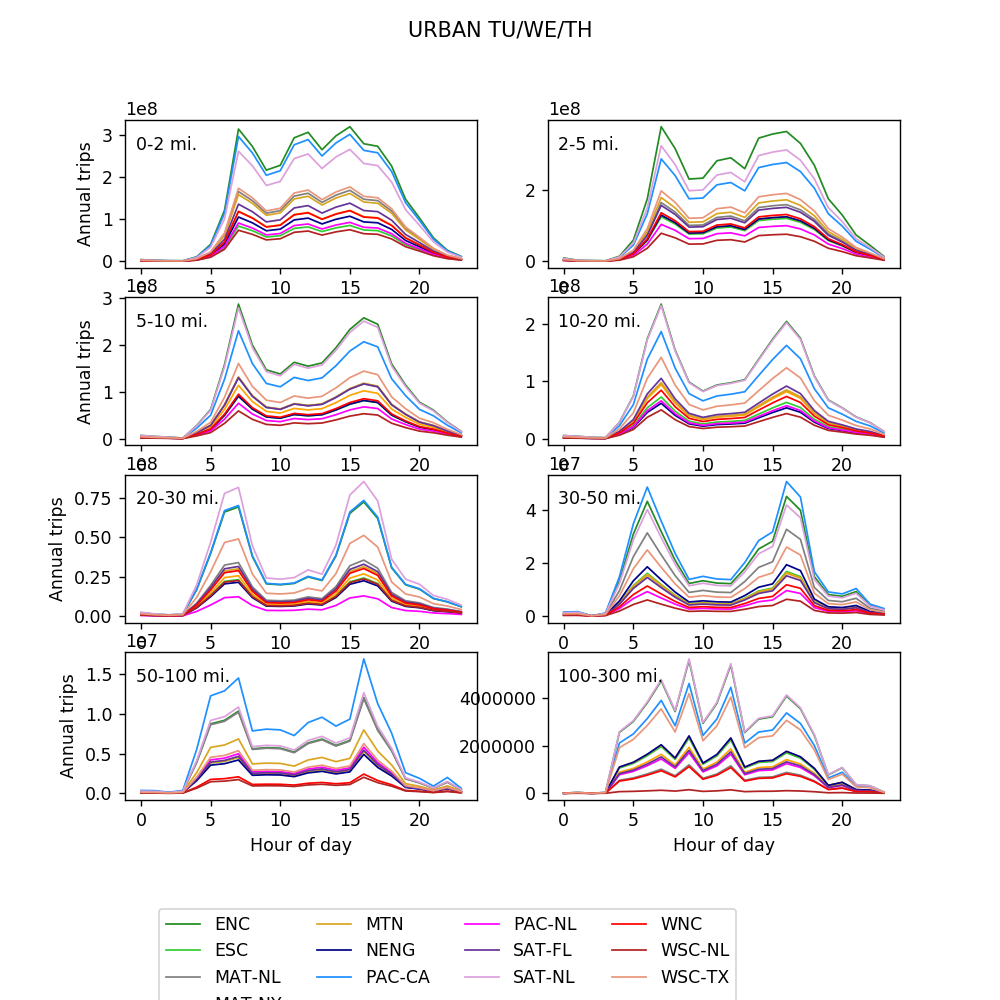

('ENC', 'URB', 'TU/WE/TH')
('ESC', 'URB', 'TU/WE/TH')
('MAT-NL', 'URB', 'TU/WE/TH')
('MAT-NY', 'URB', 'TU/WE/TH')
('MTN', 'URB', 'TU/WE/TH')
('NENG', 'URB', 'TU/WE/TH')
('PAC-CA', 'URB', 'TU/WE/TH')
('PAC-NL', 'URB', 'TU/WE/TH')
('SAT-FL', 'URB', 'TU/WE/TH')
('SAT-NL', 'URB', 'TU/WE/TH')
('WNC', 'URB', 'TU/WE/TH')
('WSC-NL', 'URB', 'TU/WE/TH')
('WSC-TX', 'URB', 'TU/WE/TH')


In [224]:
regions = dist_hour_hists.index.levels[0]
len(regions)
colors=['forestgreen','limegreen','gray', 'orange', 'goldenrod','darkblue','dodgerblue','magenta','rebeccapurple','plum',
       'red','firebrick','darksalmon']
plot_dists_by_region(dist_hour_hists[range(24)].T,regions=regions,colors=colors, urbrur='URB',wktime='TU/WE/TH')

In [225]:
if include_transit:
    tag = 'with_transit'
else:
    tag='no_transit'
hourly_profiles_agg.to_csv(data_dir+'\\binned_dists\\hourly_profiles_urb_rur_'+tag+'.csv')
dist_hists.drop('REGION', axis=1).to_csv(data_dir+'\\binned_dists\\dist_hists_by_region_'+tag+'.csv') #drop region to avoid confusion

In [226]:
hourly_profiles_agg

COUNTSRAW     COUNTSWTD   TRIPPCT
URBRURS WKTIME   MILEBIN STRTHOUR                                   
RUR     MO/FR    0-2     0               6.0  3.686144e+06  0.000966
                         1               8.0  9.804437e+06  0.002571
                         2               1.0  3.220029e+05  0.000084
                         3               1.0  4.899141e+06  0.001285
                         4              29.0  3.587461e+06  0.000941
                         5              88.0  3.292373e+07  0.008632
                         6             232.0  9.493033e+07  0.024890
                         7             680.0  2.988308e+08  0.078351
                         8             546.0  2.453281e+08  0.064323
                         9             709.0  2.261331e+08  0.059290
                         10            821.0  2.633558e+08  0.069050
                         11            984.0  3.151545e+08  0.082631
                         12            991.0  3.572513e+08  0.093669
                         13            808.0  2.912399e+08  0.076361
                         14            836.0  2.813010e+08  0.073755
                         15            922.0  3.729655e+08  0.097789
                         16            794.0  3.071244e+08  0.080526
                         17            609.0  2.514641e+08  0.065932
                         18            401.0  1.810242e+08  0.047463
                         19            220.0  9.051126e+07  0.023731
                         20            181.0  7.440041e+07  0.019507
                         21            106.0  5.901752e+07  0.015474
                         22             46.0  2.751623e+07  0.007215
                         23             29.0  2.121847e+07  0.005563
                 2-5     0               6.0  4.572063e+06  0.001941
                         1               4.0  1.554191e+06  0.000660
                         3               2.0  3.235058e+05  0.000137
                         4              32.0  1.362102e+07  0.005783
                         5              84.0  2.877349e+07  0.012215
                         6             233.0  1.046362e+08  0.044421
...                                      ...           ...       ...
URB     TU/WE/TH 50-100  17            178.0  6.594758e+07  0.071462
                         18            123.0  4.431550e+07  0.048021
                         19             74.0  1.524403e+07  0.016519
                         20             69.0  1.106856e+07  0.011994
                         21             38.0  5.375190e+06  0.005825
                         22             25.0  1.175407e+07  0.012737
                         23              9.0  3.767786e+06  0.004083
                 100-300 0               1.0  1.338488e+04  0.000037
                         1               2.0  2.409549e+05  0.000674
                         3               4.0  2.328788e+05  0.000652
                         4              48.0  1.608052e+07  0.045005
                         5              49.0  1.898431e+07  0.053132
                         6              94.0  2.389395e+07  0.066873
                         7             108.0  2.971208e+07  0.083156
                         8             110.0  2.159247e+07  0.060431
                         9             131.0  3.511721e+07  0.098283
                         10             98.0  1.848568e+07  0.051736
                         11            109.0  2.376506e+07  0.066512
                         12            137.0  3.388584e+07  0.094837
                         13             91.0  1.605296e+07  0.044928
                         14            123.0  1.958930e+07  0.054825
                         15            100.0  2.022665e+07  0.056609
                         16             94.0  2.570211e+07  0.071933
                         17             57.0  2.233748e+07  0.062516
                         18             49.0  1.526282e+07  0.042716
                         19      

## Compute seasonal variation

In [227]:
trippub['MONTH'] = trippub['TDAYDATE'].astype(str).str.slice(-2).astype(int)
trippub['SEASON'] = 'DEC-FEB'
trippub.loc[trippub['MONTH'].isin([3,4,5]), 'SEASON'] = 'MAR-MAY'
trippub.loc[trippub['MONTH'].isin([6,7,8]), 'SEASON'] = 'JUN-AUG'
trippub.loc[trippub['MONTH'].isin([9,10,11]), 'SEASON'] = 'SEP-NOV'

#specify number of days in season and in weektime
trippub.loc[trippub['SEASON']=='DEC-FEB', 'SEASDAYS'] = 31+31+28
trippub.loc[trippub['SEASON']=='MAR-MAY', 'SEASDAYS'] = 31+30+31
trippub.loc[trippub['SEASON']=='JUN-AUG', 'SEASDAYS'] = 30+31+31
trippub.loc[trippub['SEASON']=='SEP-NOV', 'SEASDAYS'] = 31+30+31
trippub['WKTIMEDAYS'] = 2
trippub.loc[trippub['WKTIME']=='TU/WE/TH', 'WKTIMEDAYS'] = 3

trippub.groupby('SEASON')['WTTRDFIN'].sum()

SEASON
DEC-FEB    5.555627e+10
JUN-AUG    6.098954e+10
MAR-MAY    6.319647e+10
SEP-NOV    5.783914e+10
Name: WTTRDFIN, dtype: float64

In [228]:
#Now plot seasonal variation in trip profiles
hourly_profiles_season = trippub.groupby(['SEASON', 
                                   'URBRURS', 
                                   'WKTIME', 
                                   'MILEBIN',
                                   'STRTHOUR'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
hourly_profiles_season['TRIPPCT'] = 0
for row in [(a,b,c,d) 
            for a in hourly_profiles_season.index.levels[0].unique() 
            for b in hourly_profiles_season.index.levels[1].unique() 
            for c in hourly_profiles_season.index.levels[2].unique() 
            for d in hourly_profiles_season.index.levels[3].unique()]:
    pct=hourly_profiles_season.loc[row,'COUNTSWTD']/(hourly_profiles_season.loc[row,'COUNTSWTD'].sum(skipna=True)+1.e-10)
    for h in pct.index.values: 
        hourly_profiles_season.loc[row+(h,), 'TRIPPCT'] = pct[h]
plotdata = hourly_profiles_season.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T
alldata = hourly_profiles_agg.unstack('STRTHOUR', fill_value=0)['TRIPPCT'].T


<IPython.core.display.Javascript object>


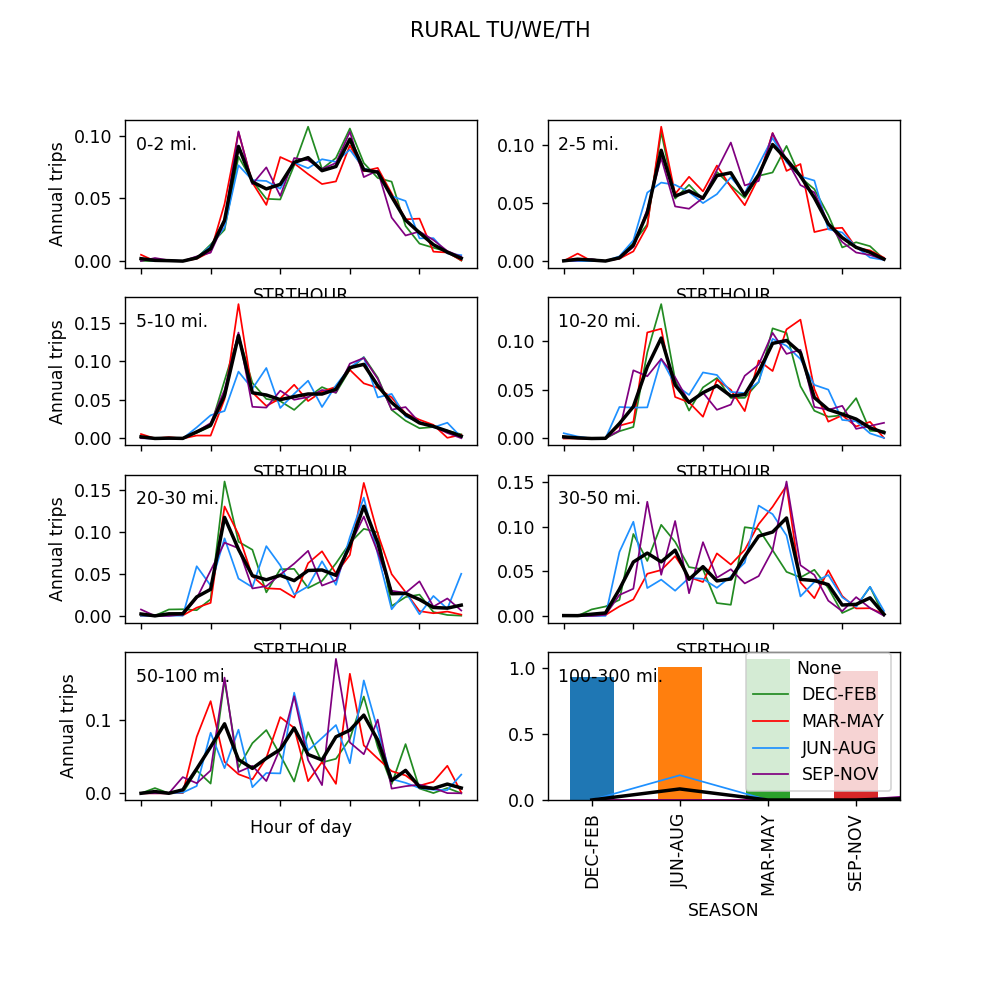

('DEC-FEB', 'RUR', 'TU/WE/TH')
('MAR-MAY', 'RUR', 'TU/WE/TH')
('JUN-AUG', 'RUR', 'TU/WE/TH')
('SEP-NOV', 'RUR', 'TU/WE/TH')


In [229]:
plot_dists_by_region(plotdata, regions=['DEC-FEB','MAR-MAY','JUN-AUG','SEP-NOV'], urbrur='RUR', wktime='TU/WE/TH', alldata=alldata)

In [230]:
#Compute total trips per day in mileage bins by season
daily_trips_season = trippub.groupby(['SEASON',#'CDIVLS', 
                                   'URBRURS', 
                                   #'WKTIME', 
                                   'MILEBIN'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
days = trippub.groupby(['SEASON',#'CDIVLS', 
                                   'URBRURS', 
                                   #'WKTIME', 
                                   'MILEBIN'])['SEASDAYS','WKTIMEDAYS'].first()
daily_trips_season['DAILYTRIPS'] = daily_trips_season['COUNTSWTD'] * 1/days['SEASDAYS']#7/days['WKTIMEDAYS']/days['SEASDAYS']
daily_trips_season

COUNTSRAW     COUNTSWTD    DAILYTRIPS
SEASON  URBRURS MILEBIN                                       
DEC-FEB RUR     0-2         8349.0  2.718310e+09  3.020344e+07
                2-5         5465.0  1.737677e+09  1.930752e+07
                5-10        4011.0  1.230154e+09  1.366838e+07
                10-20       3101.0  1.046188e+09  1.162431e+07
                20-30       1236.0  4.373098e+08  4.858997e+06
                30-50       1025.0  3.687831e+08  4.097590e+06
                50-100       601.0  2.392821e+08  2.658691e+06
                100-300      217.0  6.579422e+07  7.310469e+05
        URB     0-2        39679.0  1.323470e+10  1.470522e+08
                2-5        41599.0  1.422500e+10  1.580555e+08
                5-10       27784.0  9.281289e+09  1.031254e+08
                10-20      19335.0  6.649068e+09  7.387854e+07
                20-30       6686.0  2.325181e+09  2.583534e+07
                30-50       3775.0  1.243500e+09  1.381667e+07
                50-100      1692.0  4.899189e+08  5.443544e+06
                100-300      843.0  2.416200e+08  2.684667e+06
JUN-AUG RUR     0-2         8207.0  3.114815e+09  3.385669e+07
                2-5         5629.0  1.982654e+09  2.155058e+07
                5-10        4052.0  1.434327e+09  1.559051e+07
                10-20       3291.0  1.156125e+09  1.256658e+07
                20-30       1286.0  4.810618e+08  5.228933e+06
                30-50       1068.0  3.786120e+08  4.115348e+06
                50-100       638.0  2.281452e+08  2.479839e+06
                100-300      260.0  8.388049e+07  9.117444e+05
        URB     0-2        39073.0  1.397261e+10  1.518762e+08
                2-5        41168.0  1.510838e+10  1.642215e+08
                5-10       27762.0  1.027797e+10  1.117171e+08
                10-20      19893.0  7.564697e+09  8.222497e+07
                20-30       6691.0  2.676816e+09  2.909582e+07
                30-50       4045.0  1.460807e+09  1.587834e+07
...                            ...           ...           ...
MAR-MAY RUR     5-10        3413.0  1.359305e+09  1.477506e+07
                10-20       2811.0  1.226626e+09  1.333290e+07
                20-30       1060.0  4.508438e+08  4.900476e+06
                30-50        827.0  3.090515e+08  3.359256e+06
                50-100       469.0  2.169427e+08  2.358073e+06
                100-300      176.0  1.024630e+08  1.113729e+06
        URB     0-2        30990.0  1.458939e+10  1.585803e+08
                2-5        33114.0  1.613914e+10  1.754255e+08
                5-10       22148.0  1.083011e+10  1.177186e+08
                10-20      15921.0  8.048851e+09  8.748751e+07
                20-30       5272.0  2.650450e+09  2.880924e+07
                30-50       2977.0  1.402099e+09  1.524021e+07
                50-100      1501.0  6.070087e+08  6.597920e+06
                100-300      702.0  2.854359e+08  3.102564e+06
SEP-NOV RUR     0-2         8287.0  2.688441e+09  2.922219e+07
                2-5         5898.0  1.965764e+09  2.136700e+07
                5-10        4341.0  1.346520e+09  1.463609e+07
                10-20       3330.0  1.127545e+09  1.225592e+07
                20-30       1258.0  4.516745e+08  4.909506e+06
                30-50       1080.0  3.689270e+08  4.010076e+06
                50-100       637.0  2.005986e+08  2.180419e+06
                100-300      275.0  8.084345e+07  8.787331e+05
        URB     0-2        39909.0  1.353994e+10  1.471733e+08
                2-5        42517.0  1.438335e+10  1.563407e+08
                5-10       28254.0  9.769377e+09  1.061889e+08
                10-20      20397.0  6.906576e+09  7.507148e+07
                20-30       6905.0  2.568136e+09  2.791452e+07
                30-50       4062.0  1.448337e+09  1.574280e+07
                50-100      2006.0  6.544404e+08  7.113483e+06
                100-300     1081.0  3.164232e+08  3.439383e+06

[64 rows x 3 columns]

In [231]:
#Also compute daily average trips over the whole year
daily_trips_year = trippub.groupby([#'CDIVLS',
                                    'URBRURS', 
                                   #'WKTIME', 
                                   'MILEBIN'])['WTTRDFIN'].agg([len, 
                                                                 np.sum]).rename(columns=
                                                                                 {'len':'COUNTSRAW',
                                                                                  'sum':'COUNTSWTD'})
#days = trippub.groupby([#'CDIVLS',
#                        'URBRURS', 'WKTIME', 
#                                   'MILEBIN'])['SEASDAYS', 'WKTIMEDAYS'].first()
daily_trips_year['DAILYTRIPS'] = daily_trips_year['COUNTSWTD'] * 1/365#7/days['WKTIMEDAYS']/365
daily_trips_year

COUNTSRAW     COUNTSWTD    DAILYTRIPS
URBRURS MILEBIN                                       
RUR     0-2        31673.0  1.163880e+10  3.188714e+07
        2-5        21647.0  7.527446e+09  2.062314e+07
        5-10       15817.0  5.370307e+09  1.471317e+07
        10-20      12533.0  4.556484e+09  1.248352e+07
        20-30       4840.0  1.820890e+09  4.988739e+06
        30-50       4000.0  1.425374e+09  3.905133e+06
        50-100      2345.0  8.849686e+08  2.424572e+06
        100-300      928.0  3.329812e+08  9.122773e+05
URB     0-2       149651.0  5.533664e+10  1.516072e+08
        2-5       158398.0  5.985586e+10  1.639887e+08
        5-10      105948.0  4.015874e+10  1.100240e+08
        10-20      75546.0  2.916919e+10  7.991560e+07
        20-30      25554.0  1.022058e+10  2.800160e+07
        30-50      14859.0  5.554744e+09  1.521848e+07
        50-100      7208.0  2.411517e+09  6.606897e+06
        100-300     3835.0  1.225892e+09  3.358608e+06

In [232]:
#Divide to get multipliers
daily_trips_season['TRIPSCALESEASON'] = 1
for s in trippub['SEASON'].unique():
    daily_trips_season.loc[s, 'TRIPSCALESEASON'] = (
        daily_trips_season.loc[s,'DAILYTRIPS'].div(daily_trips_year['DAILYTRIPS']).loc[daily_trips_season.loc[s].index]).values
    
daily_trips_season

COUNTSRAW     COUNTSWTD    DAILYTRIPS  \
SEASON  URBRURS MILEBIN                                          
DEC-FEB RUR     0-2         8349.0  2.718310e+09  3.020344e+07   
                2-5         5465.0  1.737677e+09  1.930752e+07   
                5-10        4011.0  1.230154e+09  1.366838e+07   
                10-20       3101.0  1.046188e+09  1.162431e+07   
                20-30       1236.0  4.373098e+08  4.858997e+06   
                30-50       1025.0  3.687831e+08  4.097590e+06   
                50-100       601.0  2.392821e+08  2.658691e+06   
                100-300      217.0  6.579422e+07  7.310469e+05   
        URB     0-2        39679.0  1.323470e+10  1.470522e+08   
                2-5        41599.0  1.422500e+10  1.580555e+08   
                5-10       27784.0  9.281289e+09  1.031254e+08   
                10-20      19335.0  6.649068e+09  7.387854e+07   
                20-30       6686.0  2.325181e+09  2.583534e+07   
                30-50       3775.0  1.243500e+09  1.381667e+07   
                50-100      1692.0  4.899189e+08  5.443544e+06   
                100-300      843.0  2.416200e+08  2.684667e+06   
JUN-AUG RUR     0-2         8207.0  3.114815e+09  3.385669e+07   
                2-5         5629.0  1.982654e+09  2.155058e+07   
                5-10        4052.0  1.434327e+09  1.559051e+07   
                10-20       3291.0  1.156125e+09  1.256658e+07   
                20-30       1286.0  4.810618e+08  5.228933e+06   
                30-50       1068.0  3.786120e+08  4.115348e+06   
                50-100       638.0  2.281452e+08  2.479839e+06   
                100-300      260.0  8.388049e+07  9.117444e+05   
        URB     0-2        39073.0  1.397261e+10  1.518762e+08   
                2-5        41168.0  1.510838e+10  1.642215e+08   
                5-10       27762.0  1.027797e+10  1.117171e+08   
                10-20      19893.0  7.564697e+09  8.222497e+07   
                20-30       6691.0  2.676816e+09  2.909582e+07   
                30-50       4045.0  1.460807e+09  1.587834e+07   
...                            ...           ...           ...   
MAR-MAY RUR     5-10        3413.0  1.359305e+09  1.477506e+07   
                10-20       2811.0  1.226626e+09  1.333290e+07   
                20-30       1060.0  4.508438e+08  4.900476e+06   
                30-50        827.0  3.090515e+08  3.359256e+06   
                50-100       469.0  2.169427e+08  2.358073e+06   
                100-300      176.0  1.024630e+08  1.113729e+06   
        URB     0-2        30990.0  1.458939e+10  1.585803e+08   
                2-5        33114.0  1.613914e+10  1.754255e+08   
                5-10       22148.0  1.083011e+10  1.177186e+08   
                10-20      15921.0  8.048851e+09  8.748751e+07   
                20-30       5272.0  2.650450e+09  2.880924e+07   
                30-50       2977.0  1.402099e+09  1.524021e+07   
                50-100      1501.0  6.070087e+08  6.597920e+06   
                100-300      702.0  2.854359e+08  3.102564e+06   
SEP-NOV RUR     0-2         8287.0  2.688441e+09  2.922219e+07   
                2-5         5898.0  1.965764e+09  2.136700e+07   
                5-10        4341.0  1.346520e+09  1.463609e+07   
                10-20       3330.0  1.127545e+09  1.225592e+07   
                20-30       1258.0  4.516745e+08  4.909506e+06   
                30-50       1080.0  3.689270e+08  4.010076e+06   
                50-100       637.0  2.005986e+08  2.180419e+06   
                100-300      275.0  8.084345e+07  8.787331e+05   
        URB     0-2        39909.0  1.353994e+10  1.471733e+08   
                2-5        42517.0  1.438335e+10  1.563407e+08   
                5-10       28254.0  9.769377e+09  1.061889e+08   
                10-20      20397.0  6.906576e+09  7.507148e+07   
                20-30       6905.0  2.568136e+09  2.791452e+07   
                30-50       4062.0  1.448337e+09  1.574280e+07   

In [233]:
daily_trips_season.reorder_levels(['URBRURS',#'WKTIME',
                                   'MILEBIN','SEASON']).loc['RUR',#'TU/WE/TH', 
                                                            '10-20']['TRIPSCALESEASON'].plot.bar()

C:\Users\bgerke.DOMINO0\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


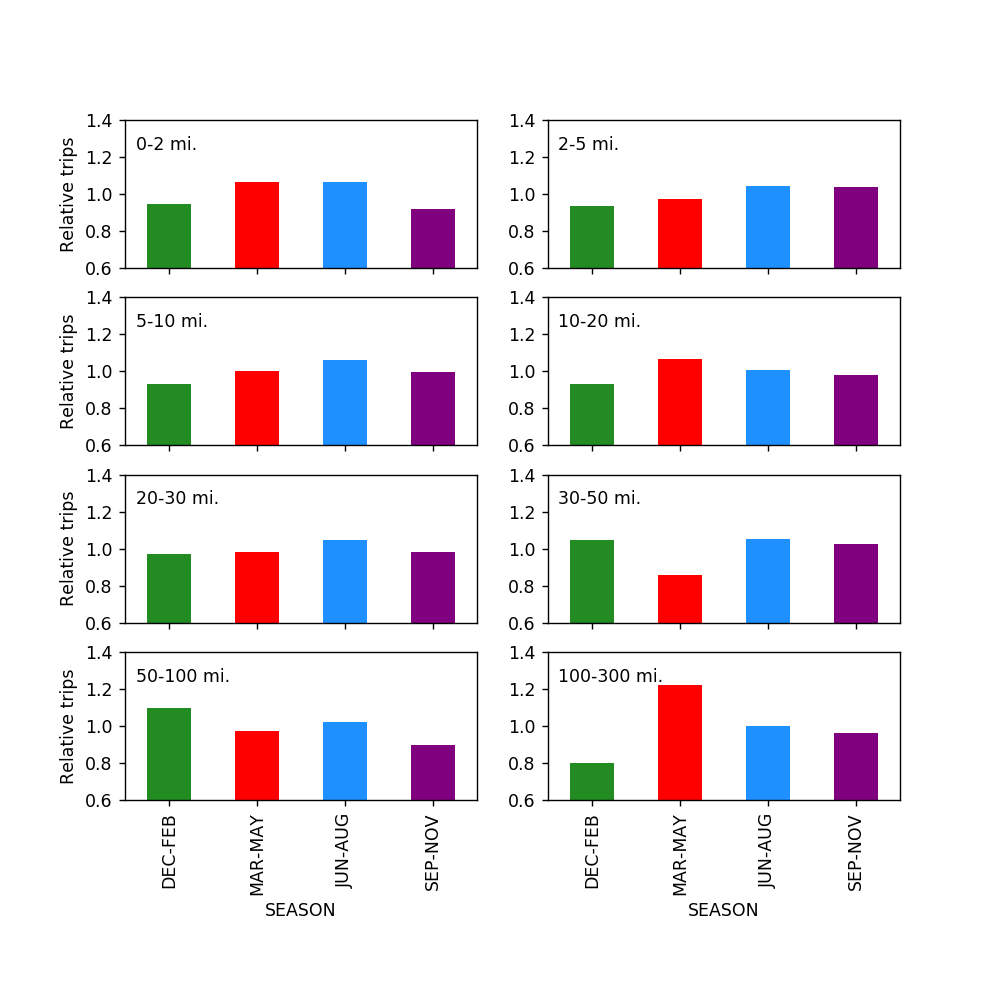

C:\Users\bgerke.DOMINO0\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.


In [234]:

#Mapping to use for sorting bars by season below
seasons = ['DEC-FEB','MAR-MAY','JUN-AUG','SEP-NOV']
mapping = {seas:i for i,seas in enumerate(seasons)}

plotdata = daily_trips_season.reorder_levels(['URBRURS',#'WKTIME',
                                              'MILEBIN','SEASON'])
ur = 'RUR'
#wt = 'TU/WE/TH'
mibins = trippub['MILEBIN'].unique().sort_values()

fig = plt.figure()
gs = gridspec.GridSpec(nrows=4, ncols=2, bottom=0.2)

for i in range(len(mibins[:-1])):
    fig.add_subplot(gs[i/2, i%2])

axs = fig.axes   
#if not colors:
colors=['forestgreen','red','dodgerblue','purple']

#plotdata.loc[ur,'0-2']
for i, milebin in enumerate(mibins):
    if type(milebin)!=type(''):
        continue
    ax=axs[i]
    pd = plotdata.loc[ur,#wt,
                      milebin]
    pd.loc[pd.index[np.argsort(pd.index.map(mapping))],'TRIPSCALESEASON'].plot.bar(ax=ax, color=colors)#subplots=True, ax=axs)
    
    miles = milebin.split('-')
    ax.annotate(str(miles[0])+'-'+str(miles[1])+' mi.', [0.03,0.8], xycoords='axes fraction')
    ax.set_ylim([0.6,1.4])
    if i <= 5:
        ax.set_xlabel('')
        ax.set_xticklabels('')
            
    if i % 2 == 0:
        ax.set_ylabel('Relative trips')

In [235]:
daily_trips_season.to_csv(data_dir+'\\binned_dists\\seasonal_scaling_'+tag+'.csv')